In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
DirPath = "/content/drive/MyDrive/Animals"

In [3]:
# Standard Stuff
import os
import uuid
import random
import numpy as np
import time

# Visuals
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Model Stuff
import tensorflow as tf
import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import LeakyReLU

# Train and Test Split
from sklearn.model_selection import train_test_split

# Early Stopping and Learning Scheduling
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Evaluation Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
#@title SET PATHS TO DATA FOLDERS
cats_folder = "/content/drive/MyDrive/Animals/cats"
dogs_folder = "/content/drive/MyDrive/Animals/dogs"


# Get the number of items in each folder
num_cats = len(os.listdir(cats_folder))
num_dogs = len(os.listdir(dogs_folder))

# Print the number of items in each folder
print("Number of items in the cats folder: ", num_cats)
print("Number of items in the dogs folder: ", num_dogs)


Number of items in the cats folder:  8350
Number of items in the dogs folder:  8683


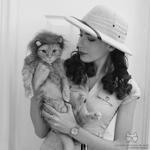

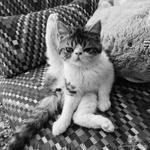

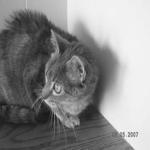

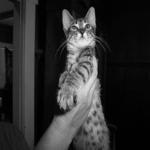

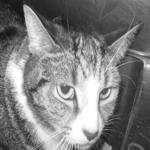

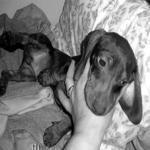

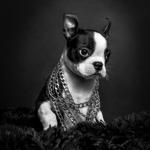

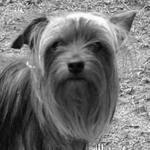

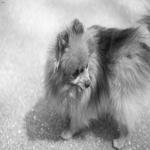

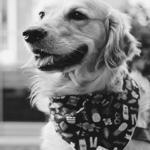

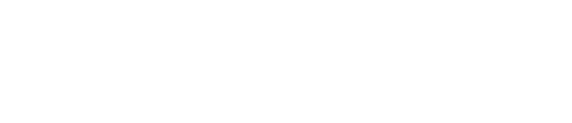

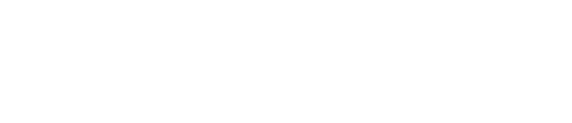

In [40]:
#@title DISPLAY 5 RANDOM SAMPLE IMAGES FOR EACH OF THE TWO CLASSES 
# Plot 5 random sample images from each folder
def plot_images(folder_path, title):
  # Get the path to 5 random images
  image_paths = random.sample(os.listdir(folder_path), 5)
  # Load the images
  images = [plt.imread(os.path.join(folder_path, path)) for path in image_paths]
  # Plot the images
  fig, axs = plt.subplots(1, 5, figsize=(10, 2))
  for i, image in enumerate(images):
    cv2_imshow(image)
    axs[i].axis("off")
  # plt.suptitle(title)
  # plt.show()

# Plot 5 random sample images from the cats folder
plot_images(cats_folder, "Sample Cat Pics")

# Plot 5 random sample images from the dogs folder
plot_images(dogs_folder, "Sample Dog Pics")

In [84]:
#@title TRAIN A CONVOLUTIONAL NEURAL NETWORK

# Create an ImageDataGenerator object for both the cats and dogs folders
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip= True,
                                   vertical_flip=True)

# Create a flow of images from the folders and set their class labels
train_generator = train_datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Animals',
    target_size = (150, 150),
    color_mode = 'grayscale',
    class_mode = 'binary',
    batch_size = 32    
)

# Show which class is assigned 0 and which is assigned 1 in this Binary classification
print("Class indices:", train_generator.class_indices)
print("\n")

# Create a training and testing set
X, y = train_generator.next()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4)

# Create Convolutional Neural Network Model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
# model.add(Dropout(rate = 0.4))
# model.add(BatchNormalization())

# model.add(Dense(64, activation='relu'))
# model.add(Dense(8, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

# Compile the model with the Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Create a ReduceLROnPlateau object to reduce the learning rate by a given 'factor' in an attempt to help not overshoot convergence and get a less than optimal solution if the validation loss does not improve after 'patience' epochs
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=9999, verbose=1)

# Create an EarlyStopping object to stop the training process early in an attempt to prevent overfitting if the val_loss does not improve after 'patience' epochs
stop_early = EarlyStopping(monitor='val_loss', patience=25)

# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[lr_reducer, stop_early],
    shuffle= True
)

Found 17033 images belonging to 2 classes.
Class indices: {'cats': 0, 'dogs': 1}


Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.6924 - accuracy: 0.5833 - val_loss: 0.5948 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 0s 75ms/step - loss: 0.7667 - accuracy: 0.6250 - val_loss: 0.6629 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 0s 73ms/step - loss: 0.6657 - accuracy: 0.6250 - val_loss: 0.6808 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 0s 73ms/step - loss: 0.6744 - accuracy: 0.6667 - val_loss: 0.6551 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 0s 75ms/step - loss: 0.6581 - accuracy: 0.6250 - val_loss: 0.6006 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 0s 76ms/step - loss: 0.6509 - accuracy: 0.6250 - val_loss: 0.5990 - val_accuracy: 0.7500 - lr: 0.0010
E

In [85]:
# Training results
y_pred_train = model.predict(X_train)
y_pred_train = np.round(y_pred_train)
print("\n[TRAINING CLASSIFICATION REPORT]\n")
print(classification_report(y_train, y_pred_train))

# Testing results
y_pred_test = model.predict(X_test)
y_pred_test = np.round(y_pred_test)
print("\n[TESTING CLASSIFICATION REPORT]\n")
print(classification_report(y_test, y_pred_test))

# Calculate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
print("\n[CONFUSION MATRIX]\n")
print(cm)

1/1 [==============================] - 0s 79ms/step

[TRAINING CLASSIFICATION REPORT]

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        15
         1.0       1.00      1.00      1.00         9

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

1/1 [==============================] - 0s 21ms/step

[TESTING CLASSIFICATION REPORT]

              precision    recall  f1-score   support

         0.0       0.71      0.83      0.77         6
         1.0       0.00      0.00      0.00         2

    accuracy                           0.62         8
   macro avg       0.36      0.42      0.38         8
weighted avg       0.54      0.62      0.58         8


[CONFUSION MATRIX]

[[5 1]
 [2 0]]


In [86]:
def curves(history):
  # Loss Curves
  plt.figure(figsize = (12, 7))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title("Loss Curves")
  plt.show()

  # Accuracy Curves
  plt.figure(figsize = (12, 7))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title("Accuracy Curves")
  plt.show()


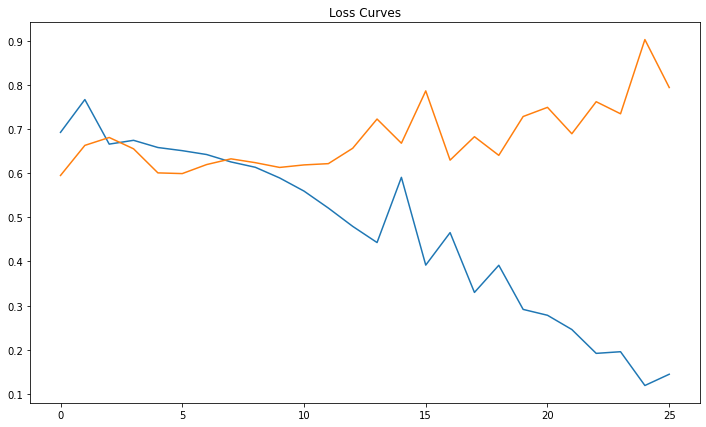

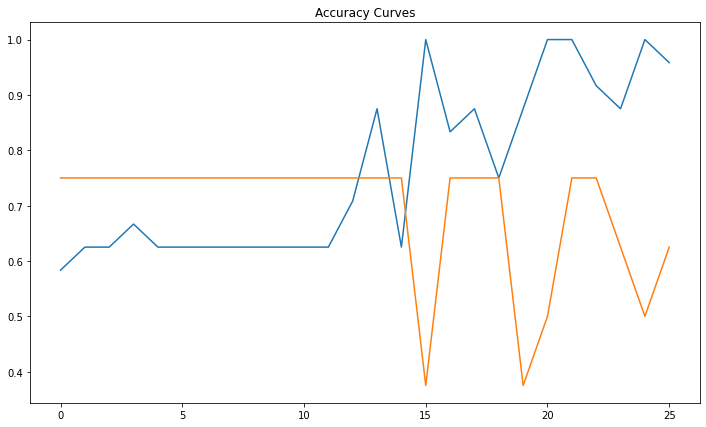

In [87]:
curves(history)

In [88]:
model.weights

[<tf.Variable 'conv2d_41/kernel:0' shape=(3, 3, 1, 64) dtype=float32, numpy=
 array([[[[-0.01714407,  0.05754639,  0.01775908, -0.04710883,
            0.053308  ,  0.09382068,  0.09617425, -0.07015375,
           -0.0820407 ,  0.01417716,  0.10136952, -0.01572936,
           -0.0491674 , -0.05732506,  0.02054019, -0.02487507,
           -0.00796187,  0.01101933,  0.05009424,  0.10199436,
            0.03132936,  0.00438642, -0.05520442, -0.00308338,
            0.10716617,  0.03401481, -0.03302607,  0.01452048,
           -0.08750281,  0.06236564, -0.07001586, -0.05543388,
            0.08467938,  0.09365696, -0.01221306, -0.02132188,
           -0.03627105, -0.02513769,  0.0430332 ,  0.03693943,
           -0.03078608,  0.00325341,  0.05500655,  0.07271638,
            0.0425766 ,  0.01053631,  0.01488642, -0.07213286,
            0.07809478,  0.055755  ,  0.0417737 ,  0.05998255,
            0.05911127,  0.06605554,  0.00950188,  0.09163132,
           -0.08129494,  0.07803682, -0.0

In [89]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 34, 34, 64)        73792     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 17, 17, 64)     